```{index} single: application; resource allocation
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} single: AMPL; sets
```
```{index} stochastic optimization
```
```{index} two-stage problem
```

# Extra: The farmer's problem and its variants

The [Farmer's Problem](https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf) is a teaching example presented in the well-known textbook by John Birge and Francois Louveaux.

* Birge, John R., and Francois Louveaux. Introduction to stochastic programming. Springer Science & Business Media, 2011.

In [ ]:
# install dependencies and select solver
!pip install -q amplpy numpy pandas matplotlib

SOLVER = "cbc"

from amplpy import AMPL, tools

ampl = tools.ampl_notebook(
    modules=["coin"], # modules to install
    license_uuid="default" # license to use
)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem Statement

In the [farmer's problem](https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf), a European farmer must allocate 500 acres of land among three different crops (wheat, corn, and sugar beets) aiming to maximize profit. The following information is given:

* Planting one acre of wheat, corn and beet costs 150, 230 and 260 euro, respectively.

* The mean yields are 2.5, 3.0, and 20.0 tons per acre for wheat, corn, and sugar beets, respectively. The yields can vary up to 20% from nominal conditions depending on weather.

* At least 200 tons of wheat and 240 tons of corn are needed for cattle feed. Cattle feed can be raised on the farm or purchased from a wholesaler. 

* The mean selling prices have been \\$170 and \\$150 per ton of wheat and corn, respectively, over the last decade. The purchase prices are 40% more due to wholesaler's margins and transportation costs.

* Sugar beets are a profitable crop expected to sell at 36 euro per ton, but there is a quota on sugar beet production. Any amount in excess of the quota can be sold at only 10 euro per ton. The farmer's quota for next year is 6,000 tons.

Create three solutions for the farmer to consider.

1. How should the farmer allocate land to maximize profit for the mean weather conditions?

2. The second solution should explicitly consider the impact of weather. How should the farmer allocate land to maximize expected profit if the yields could go up or down by 20% due to weather conditions? What is the profit under each scenario?

3. During your interview you learned the farmer needs a minimal profit each year to stay in business. How would you allocate land use to maximize the worst case profit?  

4. Determine the tradeoff between risk and return by computing the mean expected profit when the minimum required profit is the worst case found in part 3, and \\$58,000, \\$56,000, \\$54,000, \\$52,000, \\$50,000, and \\$48,000. Compare these solutions to part 2 by plotting the expected loss in profit. 

5. What would be your advice to the farmer regarding land allocation?

## Data Summary

| Scenario | Yield for wheat <br> (tons/acre)| Yield for corn <br> (tons/acre) | Yield for beets <br> (tons/acre) |
| :-- | :-: | :-: | :-: |
| Good weather | 3 | 3.6 | 24 |
| Average weather | 2.5 | 3 | 20 |
| Bad weather | 2 | 2.4 | 16 |

We first consider the case in which all the prices are fixed and not weather-dependent. The following table summarizes the data.

| Commodity | Sell <br> Price <br> (euro/ton) | Market <br> Demand <br> (tons) | Excess Price | Buy <br> Price <br> (euro/ton) | Cattle Feed <br> Required <br> (tons) | Planting <br> Cost <br> (euro/acre) |
| :-- | :--: | :--: | :--: | :--: | :--: | :--: |
| Wheat | 170 | - | _ | 238 | 200 | 150 |
| Corn | 150 | - | - | 210 | 240 | 230 |
| Beets | 36 | 6000 | 10 | 0 | - | 260 |


## Data Modeling

In [3]:
yields = pd.DataFrame(
    {
        "good": {"wheat": 3.0, "corn": 3.6, "beets": 24},
        "average": {"wheat": 2.5, "corn": 3.0, "beets": 20},
        "poor": {"wheat": 2.0, "corn": 2.4, "beets": 16},
    }
).T
display(yields)

,wheat,corn,beets
good,3.0,3.6,24.0
average,2.5,3.0,20.0
poor,2.0,2.4,16.0


In [4]:
crops = pd.DataFrame(
    {
        "wheat": {
            "planting_cost": 150,
            "sell_price": 170,
            "buy_cost": 238,
            "required": 200,
        },
        "corn": {
            "planting_cost": 230,
            "sell_price": 150,
            "buy_cost": 210,
            "required": 240,
        },
        "beets": {
            "planting_cost": 260,
            "sell_price": 36,
            "demand": 6000,
            "excess_price": 10,
        },
    }
).T

# fill NaN

bigM = 20000
crops["buy_cost"].fillna(bigM, inplace=True)
crops["demand"].fillna(bigM, inplace=True)
crops["required"].fillna(0, inplace=True)
crops["excess_price"].fillna(0, inplace=True)

display(crops)

,planting_cost,sell_price,buy_cost,required,demand,excess_price
wheat,150.0,170.0,238.0,200.0,20000.0,0.0
corn,230.0,150.0,210.0,240.0,20000.0,0.0
beets,260.0,36.0,20000.0,0.0,6000.0,10.0


## Model Building

In [5]:
%%writefile farmer.mod

set CROPS;
set SCENARIOS;

param bound;
param total_land;

param planting_cost{CROPS};
param sell_price{CROPS};
param buy_cost{CROPS};
param required{CROPS};
param demand{CROPS};
param excess_price{CROPS};

param yields{SCENARIOS, CROPS};

# first stage variables
var acres{CROPS} >= 0, <= total_land;

# second stage variables (all units in tons)
var grow{SCENARIOS, CROPS} >= 0, <= bound;
var buy{SCENARIOS, CROPS} >= 0, <= bound;
var sell{SCENARIOS, CROPS} >= 0, <= bound;
var excess{SCENARIOS, CROPS} >= 0, <= bound;

# first stage model
s.t. limit_on_planted_land: sum{c in CROPS} acres[c] <= total_land;

# second stage model
s.t. crop_yield {s in SCENARIOS, c in CROPS}:
    grow[s, c] == yields[s, c] * acres[c];
s.t. balance {s in SCENARIOS, c in CROPS}:
    grow[s, c] + buy[s, c] == sell[s, c] + required[c] + excess[s, c];

# auxiliar variable to handle the disjunction
var aux{s in SCENARIOS, c in CROPS} binary;
s.t. quota {s in SCENARIOS, c in CROPS}:
    aux[s, c] == 1 ==> (grow[s, c] <= demand[c] and excess[s, c] == 0)
    else (grow[s, c] >= demand[c] and sell[s, c] <= demand[c]);

# expressions for objective functions
var expense {s in SCENARIOS, c in CROPS} =
    planting_cost[c] * acres[c] + buy_cost[c] * buy[s, c];
var revenue {s in SCENARIOS, c in CROPS} =
    sell_price[c] * sell[s, c] + excess_price[c] * excess[s, c];
var scenario_profit {s in SCENARIOS} =
    sum{c in CROPS}(revenue[s, c] - expense[s, c]);

Overwriting farmer.mod


In [6]:
def farmer(crops, yields, total_land=500):
    
    bound = yields.max().max() * total_land
        
    m = AMPL()
    m.read('farmer.mod')

    # The 'crops' data frame has an AMPL indexing set as index ('CROPS') and AMPL parameters as 
    # columns ('planting_cost', 'sell_price', 'buy_cost', 'required', 'demand' and 'excess_price').
    # It's possible to load all the data in the data frame with the following instruction
    m.set_data(crops, 'CROPS')
    
    # The 'yields' data frame has an AMPL indexing set as index ('SCENARIOS') and another AMPL 
    # indexing set as columns ('CROPS').
    # We first need to load the data for 'SCENARIOS'.
    m.set['SCENARIOS'] = yields.index
    # Now we can load the data from the 'yields' data frame.
    m.param['yields'] = yields
    
    m.param['bound'] = bound
    m.param['total_land'] = total_land
    
    m.option['solver'] = SOLVER

    return m

In [7]:
def farm_report(m):
    print(f"Objective = {m.obj['objective'].value():0.2f}")

    # indexed by scenarios
    df_scenarios = m.var['scenario_profit'].to_pandas()
    df_scenarios.index.names = ['scenario']
    df_scenarios.rename(columns={df_scenarios.columns[0]: 'profit'},inplace=True)
    
    # indexed by crops
    df_crops = m.var['acres'].to_pandas()
    df_crops.index.names = ['crop']
    df_crops.rename(columns={df_crops.columns[0]: 'acres'},inplace=True)

    # indexed by scenarios and crops
    df_sc = m.var['grow'].to_pandas()
    df_sc.index.names = ['scenario', 'crop']
    df_sc.rename(columns={df_sc.columns[0]: 'grow'},inplace=True)
    
    df_sc['buy'] = m.var['buy'].to_pandas()
    df_sc['sell'] = m.var['sell'].to_pandas()
    df_sc['excess'] = m.var['excess'].to_pandas()
    df_sc['expense'] = m.var['expense'].to_pandas()
    df_sc['revenue'] = m.var['revenue'].to_pandas()
    df_sc['profit'] = df_sc['revenue'] - df_sc['expense']
        
    display(df_scenarios)
    display(df_crops)
    display(df_sc)

## 1. Mean Solution

In [8]:
m = farmer(crops, pd.DataFrame(yields.mean(), columns=["mean"]).T)

m.eval('maximize objective: sum{s in SCENARIOS} scenario_profit[s];')
m.get_output('solve;')

farm_report(m)

Objective = 118600.00


,profit
scenario,
mean,118600.0


,acres
crop,
beets,300.0
corn,80.0
wheat,120.0


grow  buy    sell  excess  expense   revenue    profit
scenario crop                                                           
mean     beets  6000.0    0  6000.0       0  78000.0  216000.0  138000.0
         corn    240.0    0     0.0       0  18400.0       0.0  -18400.0
         wheat   300.0    0   100.0       0  18000.0   17000.0   -1000.0

## 2. Stochastic Solution


The problem statement asks for a number of different analyses. In a consulting situation, it is possible the client would ask more "what if" questions after hearing the initial results. For these reasons, we build a function that returns an AMPL model and add the variables and expressions needed to address all parts of the problem. 

In [9]:
# maximize mean profit
m = farmer(crops, yields)

m.eval('maximize objective: (sum{s in SCENARIOS} scenario_profit[s]) / card(SCENARIOS);')
m.get_output('solve;')

farm_report(m)

Objective = 108390.00


,profit
scenario,
average,109350.0
good,167000.0
poor,48820.0


,acres
crop,
beets,250.0
corn,80.0
wheat,170.0


grow   buy    sell  excess  expense   revenue    profit
scenario crop                                                            
average  beets  5000.0   0.0  5000.0       0  65000.0  180000.0  115000.0
         corn    240.0   0.0     0.0       0  18400.0       0.0  -18400.0
         wheat   425.0   0.0   225.0       0  25500.0   38250.0   12750.0
good     beets  6000.0   0.0  6000.0       0  65000.0  216000.0  151000.0
         corn    288.0   0.0    48.0       0  18400.0    7200.0  -11200.0
         wheat   510.0   0.0   310.0       0  25500.0   52700.0   27200.0
poor     beets  4000.0   0.0  4000.0       0  65000.0  144000.0   79000.0
         corn    192.0  48.0     0.0       0  28480.0       0.0  -28480.0
         wheat   340.0   0.0   140.0       0  25500.0   23800.0   -1700.0

## 3. Worst Case Solution

In [10]:
# find worst case profit
m = farmer(crops, yields)

m.eval('var worst_case_profit;')
m.eval('s.t. lower_bound_profit{s in SCENARIOS}: worst_case_profit <= scenario_profit[s];')
m.eval('maximize objective: worst_case_profit;')
m.get_output('solve;')

farm_report(m)

Objective = 59950.00


,profit
scenario,
average,59950.0
good,59950.0
poor,59950.0


,acres
crop,
beets,375.0
corn,25.0
wheat,100.0


grow    buy    sell  excess  expense   revenue    profit
scenario crop                                                             
average  beets  7500.0    0.0  4975.0  2525.0  97500.0  204350.0  106850.0
         corn     75.0  165.0     0.0     0.0  40400.0       0.0  -40400.0
         wheat   250.0    0.0    50.0     0.0  15000.0    8500.0   -6500.0
good     beets  9000.0    0.0  3950.0  5050.0  97500.0  192700.0   95200.0
         corn     90.0  150.0     0.0     0.0  37250.0       0.0  -37250.0
         wheat   300.0    0.0   100.0     0.0  15000.0   17000.0    2000.0
poor     beets  6000.0    0.0  6000.0     0.0  97500.0  216000.0  118500.0
         corn     60.0  180.0     0.0     0.0  43550.0       0.0  -43550.0
         wheat   200.0    0.0     0.0     0.0  15000.0       0.0  -15000.0

In [11]:
worst_case_profit = m.var['worst_case_profit'].value()

# maximize expected profit subject to worst case as lower bound

m = farmer(crops, yields)

m.eval('param worst_case_profit;');
m.param['worst_case_profit'] = worst_case_profit
m.eval('s.t. lower_bound_profit{s in SCENARIOS}: worst_case_profit <= scenario_profit[s];')
m.eval('maximize objective: (sum{s in SCENARIOS} scenario_profit[s]) / card(SCENARIOS);')
m.get_output('solve;')

farm_report(m)

Objective = 86600.00


,profit
scenario,
average,86600.0
good,113250.0
poor,59950.0


,acres
crop,
beets,375.0
corn,25.0
wheat,100.0


grow    buy    sell  excess  expense   revenue    profit
scenario crop                                                             
average  beets  7500.0    0.0  6000.0  1500.0  97500.0  231000.0  133500.0
         corn     75.0  165.0     0.0     0.0  40400.0       0.0  -40400.0
         wheat   250.0    0.0    50.0     0.0  15000.0    8500.0   -6500.0
good     beets  9000.0    0.0  6000.0  3000.0  97500.0  246000.0  148500.0
         corn     90.0  150.0     0.0     0.0  37250.0       0.0  -37250.0
         wheat   300.0    0.0   100.0     0.0  15000.0   17000.0    2000.0
poor     beets  6000.0    0.0  6000.0     0.0  97500.0  216000.0  118500.0
         corn     60.0  180.0     0.0     0.0  43550.0       0.0  -43550.0
         wheat   200.0    0.0     0.0     0.0  15000.0       0.0  -15000.0

## 4. Risk versus Return

<Axes: xlabel='worst case', ylabel='mean return'>

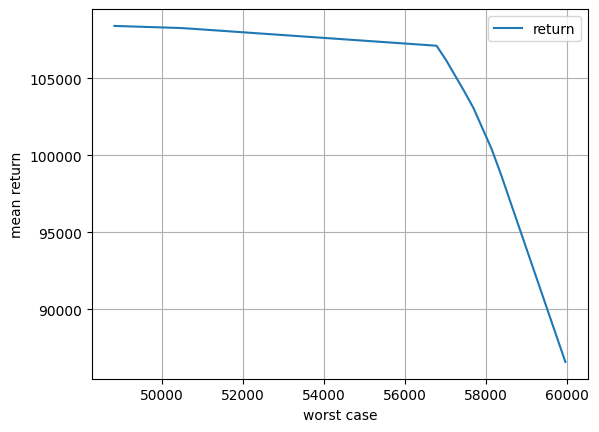

In [12]:
df = pd.DataFrame()

for wc in np.linspace(48820, 59950, 50):
    m = farmer(crops, yields)
    
    m.eval('param wc;')
    m.param['wc'] = wc
    m.eval('s.t. min_profit{s in SCENARIOS}: scenario_profit[s] >= wc;')
    # maximize mean profit
    m.eval('maximize objective: (sum{s in SCENARIOS} scenario_profit[s]) / card(SCENARIOS);')
    m.get_output('solve;')

    df.loc[wc, "return"] = m.obj['objective'].value()
    df.loc[wc, "wc"] = wc

df.plot(
    x="wc", y="return", xlabel="worst case", ylabel="mean return", grid=True
)

## 5. Recommended Planting Strategy

<Axes: xlabel='worst case', ylabel='mean return'>

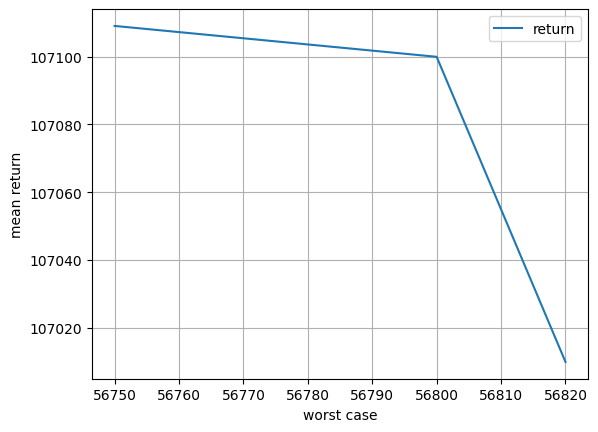

In [13]:
df = pd.DataFrame()

for wc in np.linspace(56750, 56820, 50):
    m = farmer(crops, yields)
    
    m.eval('param wc;')
    m.param['wc'] = wc
    m.eval('s.t. min_profit{s in SCENARIOS}: scenario_profit[s] >= wc;')
    # maximize mean profit
    m.eval('maximize objective: (sum{s in SCENARIOS} scenario_profit[s]) / card(SCENARIOS);')
    m.get_output('solve;')

    df.loc[wc, "return"] = m.obj['objective'].value()
    df.loc[wc, "wc"] = wc

df.plot(
    x="wc", y="return", xlabel="worst case", ylabel="mean return", grid=True
)

What we see is that the worst case can be raised from 48,820 to 56,800 (a difference of 7,980 euro) at a cost of reducing the expected from from 108,390 to 107,100 (a reduction of 1,290 euro). This improvement in worst-case performance may be worth the reduction in mean profit.

In [14]:
wc = 56800

m = farmer(crops, yields)

m.eval('param wc;')
m.param['wc'] = wc
m.eval('s.t. min_profit{s in SCENARIOS}: scenario_profit[s] >= wc;')

# maximize mean profit
m.eval('maximize objective: (sum{s in SCENARIOS} scenario_profit[s]) / card(SCENARIOS);')
m.get_output('solve;')

farm_report(m)

Objective = 107100.00


,profit
scenario,
average,117500.0
good,147000.0
poor,56800.0


,acres
crop,
beets,300.0
corn,100.0
wheat,100.0


grow  buy    sell  excess  expense   revenue    profit
scenario crop                                                           
average  beets  6000.0    0  6000.0       0  78000.0  216000.0  138000.0
         corn    300.0    0    60.0       0  23000.0    9000.0  -14000.0
         wheat   250.0    0    50.0       0  15000.0    8500.0   -6500.0
good     beets  7200.0    0  6000.0    1200  78000.0  228000.0  150000.0
         corn    360.0    0   120.0       0  23000.0   18000.0   -5000.0
         wheat   300.0    0   100.0       0  15000.0   17000.0    2000.0
poor     beets  4800.0    0  4800.0       0  78000.0  172800.0   94800.0
         corn    240.0    0     0.0       0  23000.0       0.0  -23000.0
         wheat   200.0    0     0.0       0  15000.0       0.0  -15000.0

## Bibliographic Notes

The Farmer's Problem is well known in the stochastic programming community. Examples of treatments include the following web resources:

- http://user.engineering.uiowa.edu/~dbricker/stacks_pdf1/slpwr_farmer.pdf
- https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf